In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ehtim as eh
from tqdm.notebook import tqdm
import functools
import os

import jax
import flax
from jax import numpy as jnp
from flax import linen as nn
from flax.training import train_state
from typing import Any, Callable
import optax
import sys
from flax.serialization import from_bytes

from datetime import datetime


Loading text image:  avery_sgra_eofn.txt


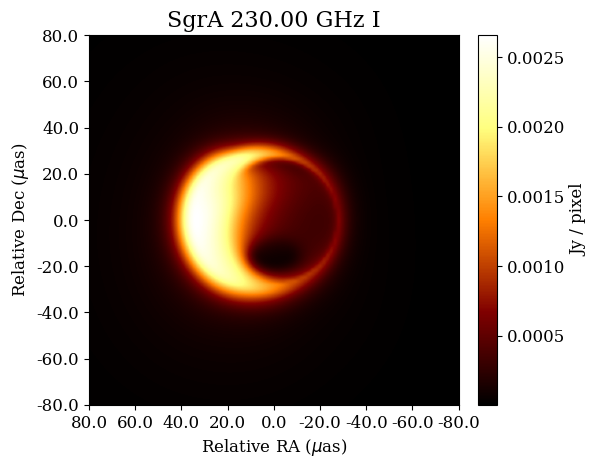

OBSERVED
Producing clean visibilities from image with nfft FT . . . 


In [ ]:
image_path = 'datasets/avery_sgra_eofn.txt'
array_path = 'datasets/EHT2017.txt'
image_true = eh.image.load_txt(image_path)
array = eh.array.load_txt(array_path)
image_true.display()

tint = 5
tadv = 600
tstart_hr = 0
tstop_hr = 24

obs = array.obsdata(tint=tint, tadv=tadv, tstart=tstart_hr, tstop=tstop_hr, ra=image_true.ra, 
                    dec=image_true.dec, rf=image_true.rf, mjd=image_true.mjd,
                    bw=image_true.rf, timetype='UTC', polrep='stokes')
print("OBSERVED")
# observe no noise 
obs = image_true.observe_same_nonoise(obs) 

In [27]:
# copying over for ease
class MLP(nn.Module):
    net_depth: int = 4
    net_width: int = 128
    activation: Callable[..., Any] = nn.relu 
    out_channel: int = 1
    do_skip: bool = True
  
    @nn.compact
    def __call__(self, x):
        """A simple Multi-Layer Preceptron (MLP) network

        Parameters
        ----------
        x: jnp.ndarray(float32), 
            [batch_size * n_samples, feature], points.
        net_depth: int, 
            the depth of the first part of MLP.
        net_width: int, 
            the width of the first part of MLP.
        activation: function, 
            the activation function used in the MLP.
        out_channel: 
            int, the number of alpha_channels.
        do_skip: boolean, 
            whether or not to use a skip connection

        Returns
        -------
        out: jnp.ndarray(float32), 
            [batch_size * n_samples, out_channel].
        """
        dense_layer = functools.partial(
            nn.Dense, kernel_init=jax.nn.initializers.he_uniform()) 

        if self.do_skip:
            skip_layer = self.net_depth // 2 
            

        inputs = x
        for i in range(self.net_depth): 
            x = dense_layer(self.net_width)(x) 
            x = self.activation(x) 
            if self.do_skip:
                if i % skip_layer == 0 and i > 0:
                    x = jnp.concatenate([x, inputs], axis=-1) 
        out = dense_layer(self.out_channel)(x) 

        return out

#NOTE: Neural nets have trouble learning high-frequency variations in direct coordinate space. 
# To solve this, map (x,y) on the image plane into a higher dimensional space of sines and cosines at multiple frequencies.      
def posenc(x, deg):
    """
    Concatenate `x` with a positional encoding of `x` with degree `deg`.
    Instead of computing [sin(x), cos(x)], we use the trig identity
    cos(x) = sin(x + pi/2) and do one vectorized call to sin([x, x+pi/2]).

    Parameters
    ----------
    x: jnp.ndarray, 
        variables to be encoded. Note that x should be in [-pi, pi].
    deg: int, 
        the degree of the encoding.

    Returns
    -------
    encoded: jnp.ndarray, 
        encoded variables.
    """
    if deg == 0:
        return x
    scales = jnp.array([2**i for i in range(deg)]) 
    xb = jnp.reshape((x[..., None, :] * scales[:, None]), 
                     list(x.shape[:-1]) + [-1])
    four_feat = safe_sin(jnp.concatenate([xb, xb + 0.5 * jnp.pi], axis=-1)) 
    return jnp.concatenate([x] + [four_feat], axis=-1) 

# wrapper around the MLP module to predict and forward pass. 
class NeuralImage(nn.Module):
    """
    Full function to predict emission at a time step.
    
    Parameters
    ----------
    posenc_deg: int, default=3
    net_depth: int, default=4
    net_width: int, default=128
    activation: Callable[..., Any], default=nn.relu
    out_channel: int default=1
    do_skip: bool, default=True
    """
    posenc_deg: int = 3
    net_depth: int = 4
    net_width: int = 128
    activation: Callable[..., Any] = nn.relu
    out_channel: int = 1
    do_skip: bool = True
    
    @nn.compact
    def __call__(self, coords):
        image_MLP = MLP(self.net_depth, self.net_width, self.activation, self.out_channel, self.do_skip)
        def predict_image(coords):
            net_output = image_MLP(posenc(coords, self.posenc_deg))
            image = nn.sigmoid(net_output[..., 0] - 10.)
            # Shift the sigmoid input back so model learns to push the logit up into an appropriate range. 
            return image
        return predict_image(coords)
    
safe_sin = lambda x: jnp.sin(x % (100 * jnp.pi))

In [30]:
# load a trained models params
npix = 100
fov = 1*image_true.fovx()
x, y = np.linspace(0, 1, npix), np.linspace(0, 1, npix)
coords = np.moveaxis(np.array(np.meshgrid(x, y, indexing='ij')), 0, -1)

predictor = NeuralImage()
template = predictor.init(jax.random.PRNGKey(0), coords)['params']
fname = "black_hole_params.msgpack"
data = open(fname, "rb").read()
params = from_bytes(template, data) #variable of interest

fov = 1*image_true.fovx()

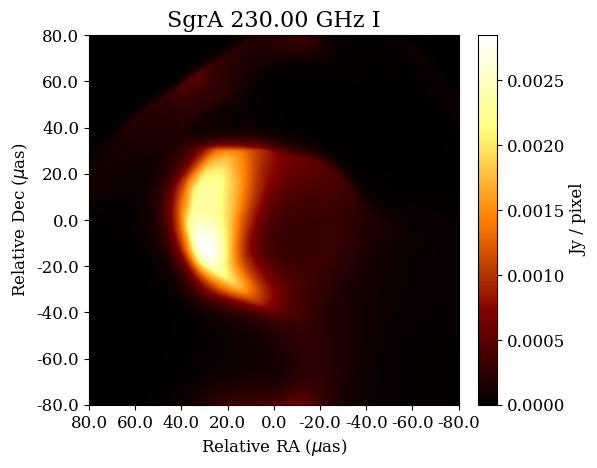

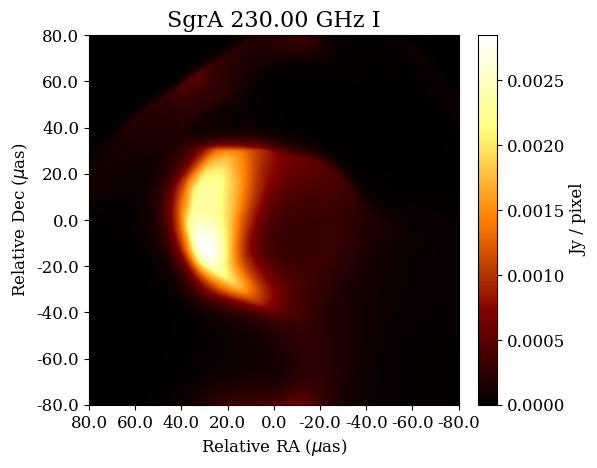

In [31]:
# Sample recostructed continuous image at higher resolution  
npix = 400
image_rec = eh.image.make_square(obs, npix, fov)
x, y = np.linspace(0, 1, image_rec.xdim), np.linspace(0, 1, image_rec.ydim)
coords = np.moveaxis(np.array(np.meshgrid(x, y, indexing='ij')), 0, -1)

image_data = predictor.apply({'params': params}, coords)
image_rec.imvec = image_data.ravel()
image_rec.display()

In [43]:
def bilinear(coords, theta):
    """gpt generated function to fill in for now"""
    gx, gy, _ = theta.shape
    # scale to vertex index space
    x = coords[..., 0] * (gx - 1)
    y = coords[..., 1] * (gy - 1)

    i0 = jnp.floor(x).astype(jnp.int32)
    j0 = jnp.floor(y).astype(jnp.int32)
    i1 = jnp.clip(i0 + 1, 0, gx - 1)
    j1 = jnp.clip(j0 + 1, 0, gy - 1)

    wx = x - i0
    wy = y - j0

    # gather four corners
    t00 = theta[i0, j0]      # lower-left
    t10 = theta[i1, j0]      # lower-right
    t01 = theta[i0, j1]      # upper-left
    t11 = theta[i1, j1]      # upper-right

    return ((1 - wx) * (1 - wy))[..., None] * t00 + \
           (     wx  * (1 - wy))[..., None] * t10 + \
           ((1 - wx) *      wy )[..., None] * t01 + \
           (     wx  *      wy )[..., None] * t11

class DeformationGrid(nn.Module):
    resolution: tuple[int, ...]

    @nn.compact
    def __call__(self, coords):
        theta = self.param(
            'theta', 
            nn.initializers.zeros, 
            self.resolution + (coords.shape[-1],)
        )
        return bilinear(coords, theta)

def forward_with_deform(params_img, params_def, coords):
    offsets = DeformationGrid.apply({'params': params_def}, coords)
    return predictor.apply({'params': params_img}, coords + offsets)

grid_res = (64, 64)
def_grid = DeformationGrid(grid_res)

In [44]:
'''prepare parameter variables for bayes rays'''
target = obs.data['vis']

npix = 100
fov = 1*image_true.fovx()
x, y = np.linspace(0, 1, npix), np.linspace(0, 1, npix)
coords = np.moveaxis(np.array(np.meshgrid(x, y, indexing='ij')), 0, -1)
prior = eh.image.make_square(obs, npix, fov)
vis, sigma, A = eh.imaging.imager_utils.chisqdata_vis(obs, prior, mask=[])

params_img = params
params_img_frozen = jax.tree_util.tree_map(jnp.array, params_img)

params_def = def_grid.init(
    jax.random.PRNGKey(0), 
    jnp.array([[0, 0]]))['params']
params_def = jax.tree_util.tree_map(jnp.zeros_like, params_def)

The bayes rays algo must be adapted to this black hole implementation. Sigma no longer can be held constant 1/2

**Negative log posterior**
$$
   h(\theta)
   = -\log\Bigl(\mathcal{N}\bigl(\mathrm{Re}\,v\mid v_\text{gt},\,\sigma_\text{re}^2\bigr)\;\times\;\mathcal{N}\bigl(\mathrm{Im}\,v\mid v_\text{gt},\,\sigma_\text{im}^2\bigr)\Bigr)
   = \mathrm{const}\;\times\;\frac{\mathrm{Re}\bigl(\varepsilon(r)\bigr)^2 + \mathrm{Im}\bigl(\varepsilon(r)\bigr)^2}{\sigma_n^2}\,.
   $$

**fisher information -> hessian**  
   $$
   I(\theta)
   = \mathbb{E}\!\biggl[\frac{J_{\mathrm{re}}^2 + J_{\mathrm{im}}^2}{\sigma^2}\biggr]
   = \frac{1}{N_{\mathrm{vis}}}\sum_{n}\frac{J_{\mathrm{re},n}^2 + J_{\mathrm{im},n}^2}{\sigma_n^2}
   = -\,H(\theta)\,.
   $$

In [ ]:
'''
The bayes rays algo must be adapted to this black hole implementation. Sigma no longer can be held constant 1/2
- h(theta) = -log( N(vis_gt_re, sigma_re^2) * N(vis_gt_im, sigma_im^2) 
           = const * ( (Re(eps(r))^2 + Im(eps(r))^2) / sigma_n^2  )
- I(theta) = E[(J_re)^2 + (J_im)^2) / sigma^2] = 1/Nvis sum( (J_re_n^2 + J_im_n^2) / sigma_n^2 ) = -H(theta)
'''
def forward_visibility(params_def, coords):
    """
    add offset and get updated visibility matrix
    """
    offsets = def_grid.apply({'params': params_def}, coords)
    img_pred = predictor.apply({'params': params_img_frozen}, coords + offsets)
    return jnp.matmul(A, img_pred.ravel())

# compute derivatives of real and imaginary parts independently otherwise H not differentiable
def re_vis(params_def, k):
    """Re(eps_theta(r))"""
    return jnp.real(forward_visibility(params_def, coords)[k])

def im_vis(params_def, k):
    """Im(eps_theta(r))"""
    return jnp.imag(forward_visibility(params_def, coords)[k])

sigma = jnp.asarray(sigma) # for jit compilation

#take the gradient of a forward_visibility (real or imaginary) over k visibilities
def grad_row(fn, k):
    g_tree = jax.grad(fn)(params_def, k)
    return g_tree['theta'] / (sigma[k] / jnp.sqrt(2)) #do we have to divide by sqrt(2) here? (sigma^2 = 1/2sigma_re^2 + 1/2 sigma_im^2)

# compute hessian in chunks
@functools.partial(jax.jit, static_argnums=(1,))
def chunk(idx, fn):
    jacobian = jax.vmap(lambda k: grad_row(fn, k))(idx) # evaluate grad_row over each i \in idx
    return jnp.sum(jacobian**2, axis=0) #z^2 = Re(z)^2 + Im(z)^2 = J'J, only compute the diagonal

def fisher_sum(chunk_size, res):
    """
    Can no longer assume sigma^2 = 1/2 or use abs in loss fn. Take the derivative of the real and imaginary parts
    and compute in chunks of rows to avoid OOM. 
    
    Args:
        chunk_size: number of rows of the jacobian to evaluate in one step
        res: grid resolution, (xdim, ydim); 2D for now
    Returns:
        J_sq: = sum( (J_re_n^2 + J_im_n^2) / sigma_n^2)
    """
    J_sq = jnp.zeros((res[0], res[1], 2))
    nvis = target.size
    for start in range(0, nvis, chunk_size):
        end = min(start+chunk_size, nvis)
        idx = jnp.arange(start, end)

        J_sq += chunk(idx, re_vis)
        J_sq += chunk(idx, im_vis)
    return J_sq

uncertainty (log scaled)


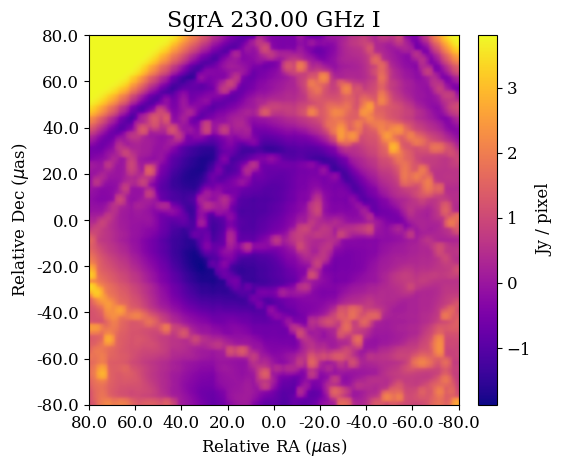

predicted image


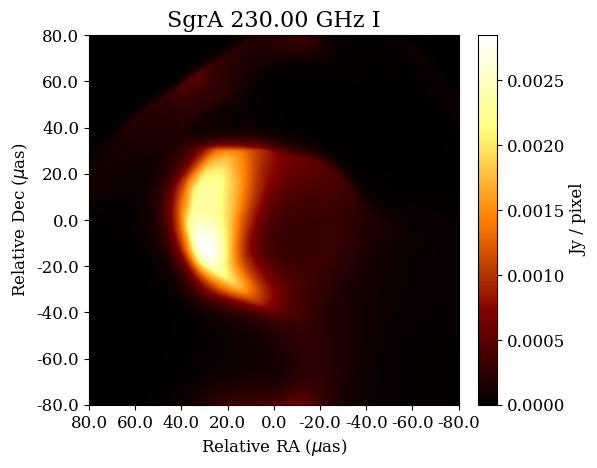

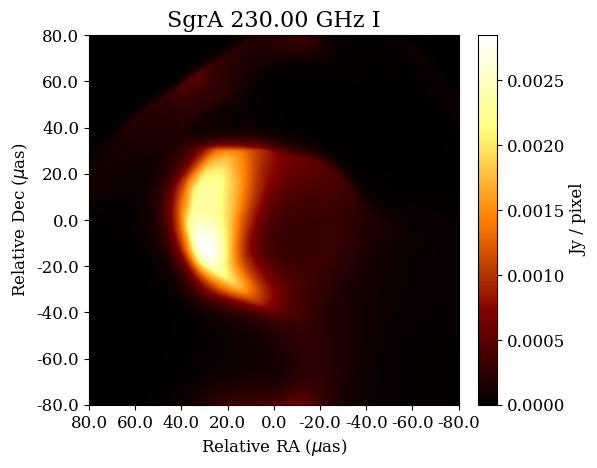

In [76]:
chunk_size = 8
J_sq = fisher_sum(chunk_size, grid_res)

lam = 1e-4 / (grid_res[0]*grid_res[1])
H_diag = J_sq/target.size + 2.0 * lam # deterministic H, no monte carlo
variance_grid = 1 / H_diag
sigma_map = jnp.linalg.norm(
    jnp.sqrt(bilinear(coords, variance_grid)), 
    axis=-1
)

#display uncertainty image (log scaled)
img_unc = eh.image.make_square(obs, npix, fov)
img_unc.imvec = jnp.log10(sigma_map + 1e-12).ravel()

print("uncertainty (log scaled)")
img_unc.display(cfun='plasma')
print("predicted image")
image_rec.display()